In [8]:
from MAT311.load import load_data, evaluate_model, plot_roc_curve, create_submission, load_data_for_validated_model
import json
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [29]:
rf = RandomForestClassifier(
    n_estimators=100,     # Number of trees (can increase for better performance)
    max_depth=None,       # Maximum depth of each tree (None = automatic)
    class_weight='balanced',  # Handles class imbalance well
    random_state=42       # For reproducibility
)

best = ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Last Interaction']
features = ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction']
safe_features = ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 
                 'Subscription Type', 'Contract Length', 'Last Interaction']
target = "Churn"

X_train, X_test, y_train, y_test, X_submission = load_data(target, best)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [30]:
actual_features = X_train.columns.tolist()

feature_importance = pd.DataFrame({
    'feature': actual_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

                      feature  importance
6               Payment Delay    0.736929
0                         Age    0.064406
5               Support Calls    0.062700
4               Support Calls    0.056520
9            Last Interaction    0.023245
2                      Tenure    0.021605
3             Usage Frequency    0.018791
1                 Gender_Male    0.012246
7  Subscription Type_Standard    0.001834
8   Subscription Type_Premium    0.001725


In [31]:
print(f"Features you specified: {len(features)}")
print(f"Features in X_train: {len(X_train.columns)}")
print(f"Feature importances: {len(rf.feature_importances_)}")

print("\nOriginal features:", features)
print("\nActual features:", X_train.columns.tolist())

Features you specified: 10
Features in X_train: 10
Feature importances: 10

Original features: ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction']

Actual features: ['Age', 'Gender_Male', 'Tenure', 'Usage Frequency', 'Support Calls', 'Support Calls', 'Payment Delay', 'Subscription Type_Standard', 'Subscription Type_Premium', 'Last Interaction']


In [18]:
from sklearn.metrics import roc_auc_score

for feature in X_train.columns:
    rf_test = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_test.fit(X_train[[feature]], y_train)
    
    proba = rf_test.predict_proba(X_test[[feature]])[:,1]
    score = roc_auc_score(y_test, proba)
    
    print(f"{feature:30s}: ROC AUC = {score:.4f}")

Age                           : ROC AUC = 0.6837
Gender_Male                   : ROC AUC = 0.5829
Tenure                        : ROC AUC = 0.5233
Usage Frequency               : ROC AUC = 0.5320
Support Calls                 : ROC AUC = 0.7336
Support Calls                 : ROC AUC = 0.7336
Payment Delay                 : ROC AUC = 0.9765
Subscription Type_Standard    : ROC AUC = 0.5052
Subscription Type_Premium     : ROC AUC = 0.5044
Contract Length_Monthly       : ROC AUC = 0.6502
Contract Length_Quarterly     : ROC AUC = 0.5764


KeyboardInterrupt: 

{
    "accuracy": 0.9642723613890782,
    "roc_auc": 0.9930167081505695,
    "precision": 0.9133470932232542,
    "recall": 0.9732414500934716,
    "f1": 0.9423435254032759,
    "true_negatives": 61138,
    "false_positives": 2519,
    "false_negatives": 730,
    "true_positives": 26551
}


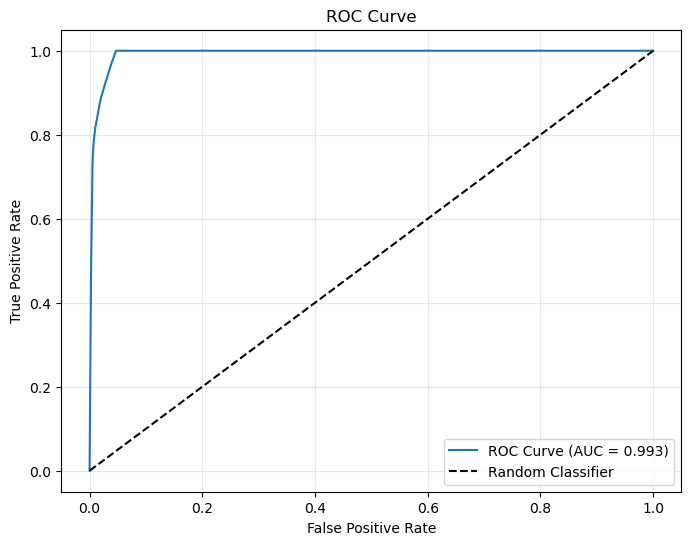

In [32]:
NN_p = rf.predict_proba(X_test)
NN_v = rf.predict(X_test)
# print(KNN_p[1])
NN_Scores = evaluate_model(y_test, NN_v, NN_p[:,1])

print(json.dumps(NN_Scores, indent=4))

plot_roc_curve(y_test, NN_p[:,1])


In [34]:
create_submission(rf, X_submission, 17)


,CustomerID,Churn
0,262106,0.00
1,37061,0.00
2,361832,0.00
3,425516,0.00
4,60597,0.01
...,...,...
133771,396573,0.01
133772,452602,0.00
133773,424958,0.01
133774,242104,0.00


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score

# All available features
all_features = ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 
                'Payment Delay', 'Subscription Type', 'Contract Length', 
                'Total Spend', 'Last Interaction']
target = "Churn"

# Load data with all features
X_train, X_test, y_train, y_test, X_submission = load_data(target, all_features)

# Create Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Use RFECV to find best features
print("Finding optimal features... (this may take a minute)")
rfecv = RFECV(estimator=rf, step=1, cv=3, scoring='roc_auc')
rfecv.fit(X_train, y_train)

# Get selected features
selected_features = [f for f, selected in zip(all_features, rfecv.support_) if selected]

print(f"\nOptimal number of features: {rfecv.n_features_}")
print(f"Best CV ROC AUC: {rfecv.cv_results_['mean_test_score'].max():.4f}")
print(f"\nSelected features: {selected_features}")

# Train final model with selected features only
rf_final = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

X_train, X_test, y_train, y_test, X_submission = load_data(target, X_train[selected_features])


rf_final.fit(X_train, y_train)

# Test the model
test_proba = rf_final.predict_proba(X_test[selected_features])[:,1]
test_predictions = rf_final.predict(X_test[selected_features])
test_score = roc_auc_score(y_test, test_proba)

print(f"\nTest ROC AUC: {test_score:.4f}")

# Evaluate and plot
scores = evaluate_model(y_test, test_predictions, test_proba)
print(json.dumps(scores, indent=4))
plot_roc_curve(y_test, test_proba)

Finding optimal features... (this may take a minute)

Optimal number of features: 10
Best CV ROC AUC: 0.9962

Selected features: ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Last Interaction']


KeyError: "['Gender', 'Subscription Type'] not in index"